In [9]:
import pandas as pd


df = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5.csv")

In [4]:
len(df)
df.head()

,Unnamed: 0,label,claim,evidence_1,evidence_2,evidence_3,evidence_4,gemma-2-2b-it,Mistral-7B-Instruct,gemma-3-1b-it,gemma-3-4b-it,gemma-3-270m-it
0,0,NOT ENOUGH INFO,Colin Kaepernick became a starting quarterback...,Colin Rand Kaepernick ([` kæpərnɪk] ; born Nov...,The 1994 San Francisco 49ers season was the te...,The San Francisco 49ers are a professional Ame...,The San Francisco 49ers entered professional f...,NOT ENOUGH INFO,SUPPORTS,SUPPORTS,SUPPORTS,"Okay, I have the provided data. I will provide..."
1,1,NOT ENOUGH INFO,Tilda Swinton is a vegan.,Katherine Matilda `` Tilda '' Swinton (born 5 ...,Veganism is both the practice of abstaining fr...,Vegetarianism [vɛdʒɪˈtɛəriənɪzəm] is the pract...,The Vegan Society is a registered charity and ...,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"Okay, I have the provided data. I will analyze..."
2,2,SUPPORTS,Fox 2000 Pictures released the film Soul Food.,Soul Food is a 1997 American comedy-drama film...,Soul Food is an American television drama seri...,Soul Food is the soundtrack to the 1997 film o...,Soul Food is a television drama that aired Wed...,SUPPORTS,REFUTES,SUPPORTS,SUPPORTS,NaN
3,3,NOT ENOUGH INFO,Anne Rice was born in New Jersey.,Anne Rice (born Howard Allen Frances O'Brien ;...,"Jane Dixon Rice (April 30 , 1913 -- March 2 , ...","Charles Edward Rice (August 7 , 1931 -- Februa...","Christopher Travis Rice (born March 11 , 1978)...",NOT ENOUGH INFO,REFUTES,"SUPPORTS, REFUTES, NOT ENOUGH INFO",NOT ENOUGH INFO,"Okay, I have the provided data. I will analyze..."
4,4,REFUTES,Telemundo is a English-language television net...,Telemundo ([teleˈmundo]) is an American Spanis...,Telemundo is an American Spanish language broa...,Telemundo is an American broadcast television ...,Noticiero Telemundo ([notiˈsjeɾo teleˈmundo] ;...,NOT ENOUGH INFO,REFUTES,SUPPORTS,SUPPORTS,"Okay, I have processed the provided data. I am..."


In [5]:
# count = 0

# for index, row in df.iterrows():
#     if row['label'] == row['Mistral-7B-Instruct']:
#         count += 1

# count

In [19]:
from typing import Any
import math

UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]
NUM_TRIALS = 20
GAP = 1
ALPHA = 0.35

# plot the weights evolution over trials for each model
def mwu_with_tracking(models: list[list[Any]], GT: list[Any]) -> list[list[float]]:
    weights = [1.] * len(models)

    weight_evolution = [weights.copy()]

    for trial in range(1, NUM_TRIALS+1):
        max_info: float = 0
        best_index: int = -1
        for i, hs in enumerate(zip(*models)):
            majority = 0.
            for l in UNIQUE_LABELS:
                curr = 0.
                for j, w in enumerate(weights):
                    if hs[j] == l:
                        curr += w
                majority = max(majority, curr)
            info = 1 - majority * 1.0 / sum(weights)
            if info > max_info:
                max_info = info
                best_index = i
        gt = GT[best_index]
        # print(f"Selected index: {best_index} with info {max_info} and GT {gt}")
        for j, m in enumerate(models):
            if m[best_index] != gt:
                weights[j] *= math.exp(-ALPHA)
        # Track weights
        if trial % GAP == 0:
            weight_evolution.append(weights.copy())
        del GT[best_index]
        for model in models:
            del model[best_index]
    best_model_index = weights.index(max(weights))
    print(f"Best model index by MWU: {best_model_index}")
    print(f"Weights: {weights}")
    return weight_evolution

def plot_weight_and_accuracy(weight_evolution: list[list[float]], accuracies: list[float]) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for i, weights in enumerate(per_model_weights):
        acc = accuracies[i]
        plt.plot(weights, label=f"Model {i} (acc={acc:.3f})")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()



Best model index by MWU: 3
Weights: [0.002605840518408499, 0.0052475183991813855, 0.007446583070924342, 0.04285212686704019]


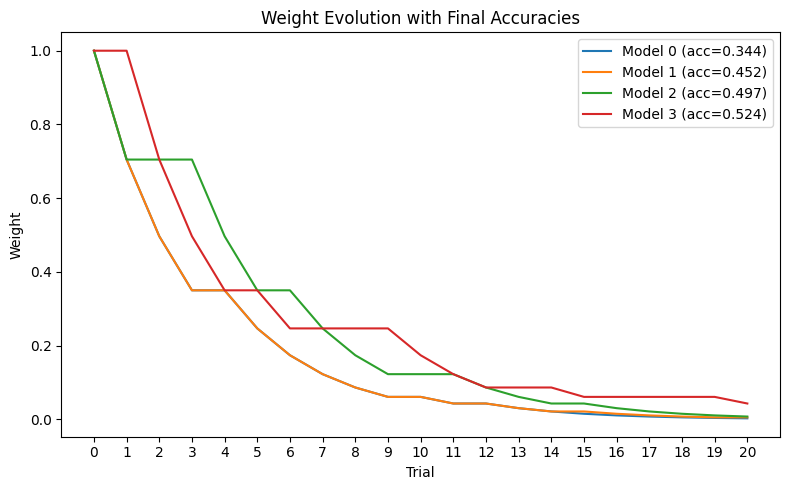

In [20]:
FINAL_ACC = [7806./22682, 10250./22682, 11277./22682, 11892./22682]
gemma_3_1b_it = df["gemma-3-1b-it"].tolist()
gemma_2_2b_it = df["gemma-2-2b-it"].tolist()
gemma_3_4b_it = df["gemma-3-4b-it"].tolist()
mistral_7b_instruct = df["Mistral-7B-Instruct"].tolist()
models = [gemma_3_1b_it, gemma_2_2b_it, gemma_3_4b_it, mistral_7b_instruct]
gt = df["label"].tolist()
weight_evolution = mwu_with_tracking(models, gt)
plot_weight_and_accuracy(weight_evolution, FINAL_ACC)

Best model index by random sampling: 2
Correct among random samples: [38.0, 50.0, 61.0, 61.0]


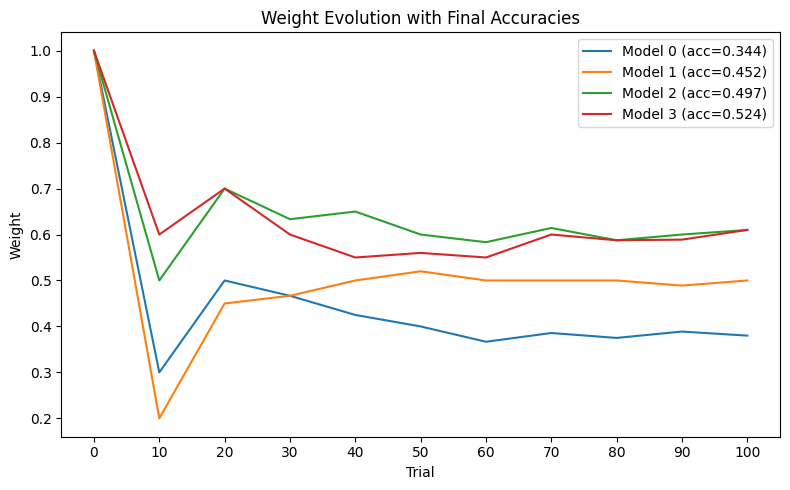

In [144]:
def random_sample_with_tracking(models: list[list[Any]], GT: list[Any]) -> list[list[float]]:
    count_correct = [0.] * len(models)

    acc_evolution = [[1.0] * len(models)]

    for i, g in enumerate(GT):
        for j, m in enumerate(models):
            if m[i] == g:
                count_correct[j] += 1
        if (i + 1) % GAP == 0:
            acc_evolution.append([j * 1.0 / (i+1) for j in count_correct.copy()])
    
    best_model_index = count_correct.index(max(count_correct))
    print(f"Best model index by random sampling: {best_model_index}")
    print(f"Correct among random samples: {count_correct}")
    return acc_evolution 

df_100 = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5_sample_100.csv")
gemma_3_1b_it_100 = df_100["gemma-3-1b-it"].tolist()
gemma_2_2b_it_100 = df_100["gemma-2-2b-it"].tolist()
gemma_3_4b_it_100 = df_100["gemma-3-4b-it"].tolist()
mistral_7b_instruct_100 = df_100["Mistral-7B-Instruct"].tolist()
models_100 = [gemma_3_1b_it_100, gemma_2_2b_it_100, gemma_3_4b_it_100, mistral_7b_instruct_100]
gt_100 = df_100["label"].tolist()
acc_100_evolution = random_sample_with_tracking(models_100, gt_100)
plot_weight_and_accuracy(acc_100_evolution, FINAL_ACC)

Best model index by random sampling: 3
Correct among random samples: [71.0, 95.0, 112.0, 114.0]


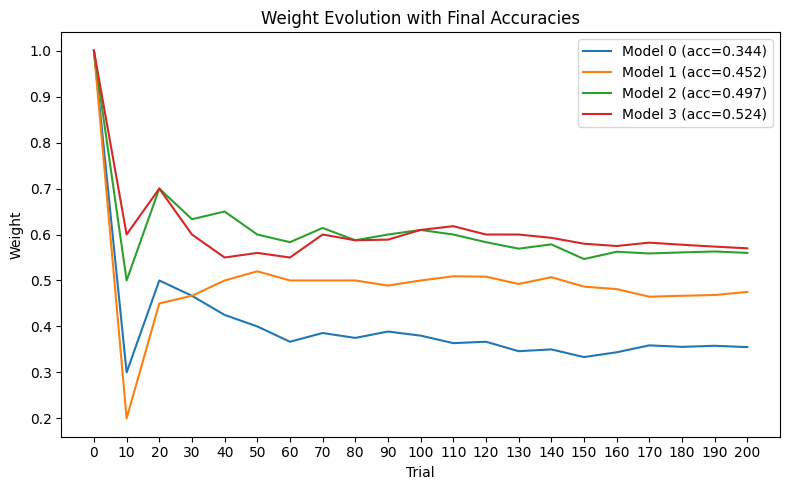

In [145]:
df_200 = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5_sample_200.csv")
gemma_3_1b_it_200 = df_200["gemma-3-1b-it"].tolist()
gemma_2_2b_it_200 = df_200["gemma-2-2b-it"].tolist()
gemma_3_4b_it_200 = df_200["gemma-3-4b-it"].tolist()
mistral_7b_instruct_200 = df_200["Mistral-7B-Instruct"].tolist()
models_200 = [gemma_3_1b_it_200, gemma_2_2b_it_200, gemma_3_4b_it_200, mistral_7b_instruct_200]
gt_200 = df_200["label"].tolist()
acc_200_evolution = random_sample_with_tracking(models_200, gt_200)
plot_weight_and_accuracy(acc_200_evolution, FINAL_ACC)

In [1]:
# unweighted majority voting
import pandas as pd

df = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5.csv")
UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]

models = ["gemma-3-1b-it", "gemma-2-2b-it", "gemma-3-4b-it", "Mistral-7B-Instruct"]

count = 0
for index, row in df.iterrows():
    majority = 0
    for l in UNIQUE_LABELS:
        cur = 0
        for m in models:
            if row[m] == l:
                cur += 1
        if cur > majority:
            majority = cur
            label = l
    if label == row["label"]:
        count += 1
print(count)


11077


In [25]:
# random examples

from typing import Any
import math
import random 

UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]
NUM_TRIALS = 10
GAP = 1
ALPHA = 0.35

# plot the weights evolution over trials for each model
def mwu_random_examples(models: list[list[Any]], GT: list[Any]) -> list[list[float]]:
    weights = [1.] * len(models)

    weight_evolution = [weights.copy()]

    for trial in range(1, NUM_TRIALS+1):
        chosen_index = random.choice(range(len(GT)))
        gt = GT[chosen_index]
        # print(f"Selected index: {chosen_index} with info {max_info} and GT {gt}")
        for j, m in enumerate(models):
            if m[chosen_index] != gt:
                weights[j] *= math.exp(-ALPHA)
        # Track weights
        if trial % GAP == 0:
            weight_evolution.append(weights.copy())
        del GT[chosen_index]
        for model in models:
            del model[chosen_index]
    best_model_index = weights.index(max(weights))
    print(f"Best model index by MWU: {best_model_index}")
    print(f"Weights: {weights}")
    return weight_evolution

def plot_weight_and_accuracy(weight_evolution: list[list[float]], accuracies: list[float]) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for i, weights in enumerate(per_model_weights):
        acc = accuracies[i]
        plt.plot(weights, label=f"Model {i} (acc={acc:.3f})")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()



Best model index by MWU: 2
Weights: [0.08629358649937052, 0.12245642825298192, 0.3499377491111554, 0.17377394345044514]


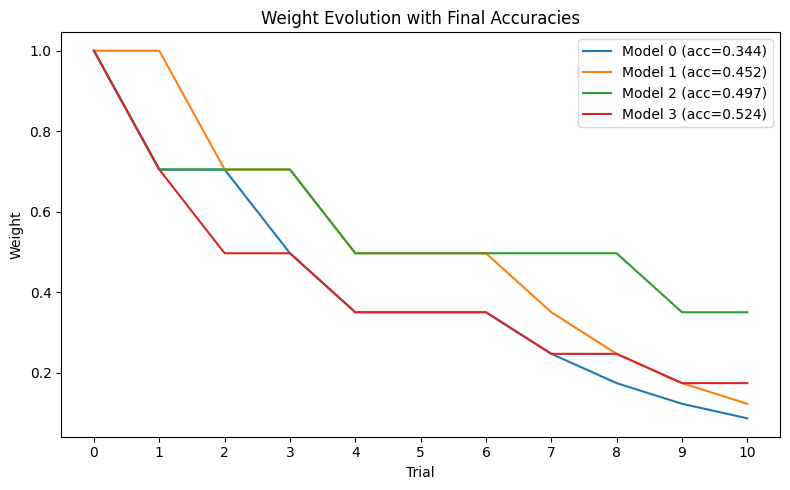

In [26]:
FINAL_ACC = [7806./22682, 10250./22682, 11277./22682, 11892./22682]
gemma_3_1b_it = df["gemma-3-1b-it"].tolist()
gemma_2_2b_it = df["gemma-2-2b-it"].tolist()
gemma_3_4b_it = df["gemma-3-4b-it"].tolist()
mistral_7b_instruct = df["Mistral-7B-Instruct"].tolist()
models = [gemma_3_1b_it, gemma_2_2b_it, gemma_3_4b_it, mistral_7b_instruct]
gt = df["label"].tolist()
weight_evolution = mwu_random_examples(models, gt)
plot_weight_and_accuracy(weight_evolution, FINAL_ACC)

In [32]:
# mwu informative only
from typing import Any
import math

UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]
NUM_TRIALS = 10
GAP = 1
ALPHA = 0.35

# plot the weights evolution over trials for each model
def mwu_informative_only(models: list[list[Any]], GT: list[Any]) -> list[list[float]]:
    weights = [1.] * len(models)
    n_models = len(models)

    weight_evolution = [weights.copy()]

    for trial in range(1, NUM_TRIALS+1):
        max_info: float = 0
        best_index: int = -1
        for i, hs in enumerate(zip(*models)):
            majority = 0.
            for l in UNIQUE_LABELS:
                curr = 0.
                for j, _ in enumerate(weights):
                    if hs[j] == l:
                        curr += 1
                majority = max(majority, curr)
            info = 1 - majority * 1.0 / n_models
            if info > max_info:
                max_info = info
                best_index = i
        gt = GT[best_index]
        # print(f"Selected index: {best_index} with info {max_info} and GT {gt}")
        for j, m in enumerate(models):
            if m[best_index] != gt:
                weights[j] *= math.exp(-ALPHA)
        # Track weights
        if trial % GAP == 0:
            weight_evolution.append(weights.copy())
        del GT[best_index]
        for model in models:
            del model[best_index]
    best_model_index = weights.index(max(weights))
    print(f"Best model index by MWU: {best_model_index}")
    print(f"Weights: {weights}")
    return weight_evolution

def plot_weight_and_accuracy(weight_evolution: list[list[float]], accuracies: list[float]) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for i, weights in enumerate(per_model_weights):
        acc = accuracies[i]
        plt.plot(weights, label=f"Model {i} (acc={acc:.3f})")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()



Best model index by MWU: 3
Weights: [0.030197383422318504, 0.04285212686704019, 0.12245642825298192, 0.17377394345044514]


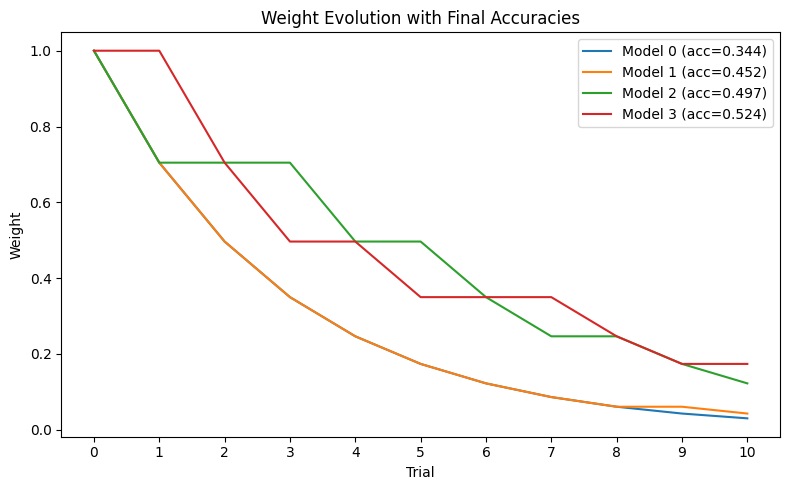

In [33]:
FINAL_ACC = [7806./22682, 10250./22682, 11277./22682, 11892./22682]
gemma_3_1b_it = df["gemma-3-1b-it"].tolist()
gemma_2_2b_it = df["gemma-2-2b-it"].tolist()
gemma_3_4b_it = df["gemma-3-4b-it"].tolist()
mistral_7b_instruct = df["Mistral-7B-Instruct"].tolist()
models = [gemma_3_1b_it, gemma_2_2b_it, gemma_3_4b_it, mistral_7b_instruct]
gt = df["label"].tolist()
weight_evolution = mwu_informative_only(models, gt)
plot_weight_and_accuracy(weight_evolution, FINAL_ACC)

In [35]:
# weighted majority voting
# weights = [0.02732372244729254, 0.04978706836786392, 0.06081006262521794, 0.16529888822158648] # 20 interactive informative examples - alpha = 0.2
# weights = [0.002605840518408499, 0.0052475183991813855, 0.007446583070924342, 0.04285212686704019] # 20 interactive informative examples - alpha = 0.35
# weights = [0.06081006262521797, 0.06081006262521797, 0.12245642825298192, 0.17377394345044514] # 10 interactive informative examples - alpha = 0.35
# weights = [0.014995576820477708, 0.04285212686704019, 0.08629358649937052, 0.010567204383852655] # 20 random examples - alpha = 0.35
# weights = [0.08629358649937052, 0.12245642825298192, 0.3499377491111554, 0.17377394345044514] # 10 random examples - alpha = 0.35
# 20 informative only examples - alpha = 0.35
# weights = [0.0009118819655545165, 0.0052475183991813855, 0.0052475183991813855, 0.030197383422318504]
# 10 informative only examples - alpha = 0.35
weights = [0.030197383422318504, 0.04285212686704019, 0.12245642825298192, 0.17377394345044514]


df = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5.csv")
UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]

models = ["gemma-3-1b-it", "gemma-2-2b-it", "gemma-3-4b-it", "Mistral-7B-Instruct"]

count = 0
for index, row in df.iterrows():
    majority = 0
    for l in UNIQUE_LABELS:
        cur = 0
        for w, m in zip(weights, models):
            if row[m] == l:
                cur += w
        if cur > majority:
            majority = cur
            label = l
    if label == row["label"]:
        count += 1
print(count)

12067
